# <center> Decision Tree</center>

![tree](./pics/tree.jpg)

## Goals of lecture 

* Understand decision tree algorithm, can solve both classification and regression problems
* Terminology: Entropy
* Use Apache Spark to solve the same classification problem in lecture 12 with decision tree algorithm
* Use Apache Spark to solve the same regression problem in lecture 11 with decision treem algorithm

## Bird's eye view

![decision-tree](./pics/decision-tree.png)

Think of x, y as
* $ x^{(1)} $ are you in selective school
* $ x^{(2)} $ average learning hours per day
* $ y $ enter university

Or think of x, y as
* $ x^{(1)} $ weight
* $ x^{(2)} $ height
* $ y $ risk of diabetes

#### if-else logic

#### Key question is how to construct a tree
* which feature goes to the root node, which feature is the second, third ...
* how to determine value $a$
* how deep is the tree

## Just a bit Information Theory

### How to measure information

* 明天太阳会从东方升起
* 明天会下雨
* 明天你会拿到一个年薪百万的offer

### Big Ideas

* $ I(x) $ ~ $ P(x) $

* $ I(x_1, x_2) = I(x_1) + I(x_2) $

* $ I(x) >= 0 $

### Information

$$
I(x) = \log_2 \frac {1} {P(x)} = -\log_2{P(x)}
$$

### Entropy

$$
H(x) = E[I(x)] = \sum_{1=1}^n P(x_i)I(x_i) = -\sum_{1=1}^n p_i \log_2 p_i
$$

### Flip a coin

* head, $ P(x_1) = \frac 1 2 $
* tail, $ P(x_2) = \frac 1 2 $
* Entroy, $ H(x) = -\frac 1 2\log_2 \frac 1 2 - \frac 1 2\log_2 \frac 1 2 = 1 $

In [1]:
import numpy as np
from matplotlib import pyplot as plt

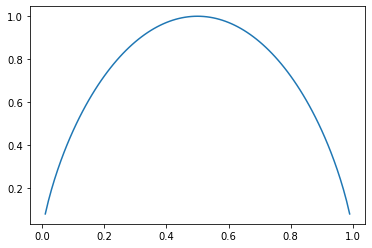

In [2]:
p = np.arange(0.01, 1.0, 0.01)
y = -p*np.log2(p) - (1-p)*np.log2(1-p)
plt.plot(p, y, '-')
plt.show()

#### Entropy as a measure of uncertainty

### Conditional Entropy

$$
H(Y|X) = \sum_{i=1}^n p_i H(Y|X=x_i)
$$

### Information Gain

$$
g(D, A) = H(D) - H(D|A)
$$

### Quiz

* 考上大学，考不上大学的概率各位50%
* 平均每天学习10小时以上的条件下，考上大学的概率95%，考不上大学的概率5%

计算"每天学习10小时以上"的信息增益

In [3]:
h = -1/2*np.log2(1/2) - 1/2*np.log2(1/2)
h

1.0

In [4]:
h10 = -0.95*np.log2(0.95) - 0.95*np.log2(0.95)
h10

0.14060110474317616

In [5]:
h - h10

0.8593988952568239

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DecisionTree").getOrCreate()

In [7]:
loan = spark.read.csv('./data/loan/loan.csv', header=True, inferSchema=True)
loan.show()

+---+---------+--------+----------+------+------------+
| id|age_group|have_job|have_house|credit|approve_loan|
+---+---------+--------+----------+------+------------+
|  1|        y|       n|         n|     m|           n|
|  2|        y|       n|         n|     g|           n|
|  3|        y|       y|         n|     g|           y|
|  4|        y|       y|         y|     m|           y|
|  5|        y|       n|         n|     m|           n|
|  6|        m|       n|         n|     m|           n|
|  7|        m|       n|         n|     g|           n|
|  8|        m|       y|         y|     g|           y|
|  9|        m|       n|         y|     e|           y|
| 10|        m|       n|         y|     e|           y|
| 11|        o|       n|         y|     e|           y|
| 12|        o|       n|         y|     g|           y|
| 13|        o|       y|         n|     g|           y|
| 14|        o|       y|         n|     e|           y|
| 15|        o|       n|         n|     m|      

* age_group: Young, Young, Middle-age, Old
* have_job: Yes, No
* have_house: Yes, No
* credit: Medium, Good, Extremely-good
* approve_loan: Yes, No

### What is the best feature in above table?

In [8]:
loan.groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    6|
|           y|    9|
+------------+-----+



#### Initial Entropy $H(D)$

In [9]:
h = -6/15*np.log2(6/15) - 9/15*np.log2(9/15)
h

0.9709505944546686

#### Conditional Entropy $H(D|age)$

In [10]:
loan.groupBy('age_group').count().show()

+---------+-----+
|age_group|count|
+---------+-----+
|        m|    5|
|        o|    5|
|        y|    5|
+---------+-----+



In [11]:
loan.filter('age_group = "y"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    3|
|           y|    2|
+------------+-----+



In [12]:
loan.filter('age_group = "m"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    2|
|           y|    3|
+------------+-----+



In [13]:
loan.filter('age_group = "o"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    1|
|           y|    4|
+------------+-----+



In [14]:
h_age = ( 5/15 * (-3/5*np.log2(3/5) - 2/5*np.log2(2/5)) + 
          5/15 * (-3/5*np.log2(3/5) - 2/5*np.log2(2/5)) + 
          5/15 * (-1/5*np.log2(1/5) - 4/5*np.log2(4/5)))
h_age

0.8879430945988998

#### Information Gain of age $H(D) - H(D|age)$

In [15]:
ig_age = h - h_age
ig_age

0.08300749985576883

#### Conditional Entropy $H(D|job)$

In [16]:
loan.groupBy('have_job').count().show()

+--------+-----+
|have_job|count|
+--------+-----+
|       n|   10|
|       y|    5|
+--------+-----+



In [17]:
loan.filter('have_job = "y"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           y|    5|
+------------+-----+



In [18]:
loan.filter('have_job = "n"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    6|
|           y|    4|
+------------+-----+



In [19]:
h_job = ( 10/15 * (-6/10*np.log2(6/10) - 4/10*np.log2(4/10)) + 
          0)
h_job

0.6473003963031123

#### Information Gain of job $H(D) - H(D|job)$

In [20]:
ig_job = h - h_job
ig_job

0.32365019815155627

#### Conditional Entropy $H(D|house)$

In [21]:
loan.groupBy('have_house').count().show()

+----------+-----+
|have_house|count|
+----------+-----+
|         n|    9|
|         y|    6|
+----------+-----+



In [22]:
loan.filter('have_house = "y"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           y|    6|
+------------+-----+



In [23]:
loan.filter('have_house = "n"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    6|
|           y|    3|
+------------+-----+



In [24]:
h_house = ( 9/15 * (-6/9*np.log2(6/9) - 3/9*np.log2(3/9)) + 
           0)
h_house

0.5509775004326937

#### Information Gain of house $H(D) - H(D|house)$

In [25]:
ig_house = h - h_house
ig_house

0.4199730940219749

#### Conditional Entropy $H(D|credit)$

In [26]:
loan.groupBy('credit').count().show()

+------+-----+
|credit|count|
+------+-----+
|     g|    6|
|     m|    5|
|     e|    4|
+------+-----+



In [27]:
loan.filter('credit = "m"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    4|
|           y|    1|
+------------+-----+



In [28]:
loan.filter('credit = "g"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           n|    2|
|           y|    4|
+------------+-----+



In [29]:
loan.filter('credit = "e"').groupBy('approve_loan').count().show()

+------------+-----+
|approve_loan|count|
+------------+-----+
|           y|    4|
+------------+-----+



In [30]:
h_credit = ( 5/15 * (-4/5*np.log2(4/5) - 1/5*np.log2(1/5)) + 
          6/15 * (-2/6*np.log2(2/6) - 4/6*np.log2(4/6)) + 
          0)
h_credit

0.6079610319175832

#### Information Gain of house $H(D) - H(D|house)$

In [31]:
ig_credit = h - h_credit
ig_credit

0.36298956253708536

In [32]:
ig_age, ig_job, ig_house, ig_credit

(0.08300749985576883,
 0.32365019815155627,
 0.4199730940219749,
 0.36298956253708536)

#### ig_house has the biggest information gain, which is the best feature

<hr/>

### Let's solve the same bank marketing problem with Decision Tree algorithm

In [33]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('decision-tree').getOrCreate()
df = spark.read.csv('./data/bank/bank.csv', header=True, inferSchema=True)

In [34]:
df.show(5, False)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [35]:
# contact, day, month are irrelevant for analysis and prediction
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')

In [36]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

In [37]:
# index and encode
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [38]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [39]:
# for numeric columsn, we just use them directly
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# VectorAssembler, vectorize those input columns specified by assemblerInputs
# put the output into a new column called features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [40]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [44]:
train, test = df.randomSplit([0.8, 0.2], seed = 2019)

In [49]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------+-----+-------------+----------+--------------------+
|age|    job|label|rawPrediction|prediction|         probability|
+---+-------+-----+-------------+----------+--------------------+
| 18|student|  1.0|   [2.0,17.0]|       1.0|[0.10526315789473...|
| 19|student|  0.0|    [0.0,5.0]|       1.0|           [0.0,1.0]|
| 19|student|  1.0| [96.0,165.0]|       1.0|[0.36781609195402...|
| 19|student|  1.0| [23.0,124.0]|       1.0|[0.15646258503401...|
| 20| admin.|  0.0|    [5.0,2.0]|       0.0|[0.71428571428571...|
| 20|student|  0.0|   [2.0,17.0]|       1.0|[0.10526315789473...|
| 20|student|  0.0|    [0.0,5.0]|       1.0|           [0.0,1.0]|
| 20|student|  1.0|    [0.0,5.0]|       1.0|           [0.0,1.0]|
| 20|student|  1.0| [23.0,124.0]|       1.0|[0.15646258503401...|
| 20|student|  1.0| [23.0,124.0]|       1.0|[0.15646258503401...|
+---+-------+-----+-------------+----------+--------------------+
only showing top 10 rows



In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7655935890839407


<hr/>

![Quinlan](./pics/Quinlan.png)

<hr/>

### What if $y$ is continuous variable instead of categorical

### What if feature is continuous variable instad of categorical